# **Task 2**
**Clustering**: In task 2 a new dataset will be introduced. The new dataset will be partially merged with the one obtained in feature engineering and preprocessing. The goal will be to create clusters made up of players with similar characteristics. The final partition will be used to scout young talents.

Imported libraries

In [1]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import numpy as np
from pyspark.sql.functions import udf
from pyspark.sql.types import BinaryType
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.ml.feature import *
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt


Creating the pyspark session

In [2]:
# Create the session
conf = SparkConf(). \
    set('spark.ui.port', "4050"). \
    set('spark.executor.memory', '15G'). \
    set('spark.driver.memory', '50G'). \
    set('spark.driver.maxResultSize', '40G'). \
    setAppName("PySparkProject"). \
    set('spark.executor.cores', "10"). \
    setMaster("local[*]")

sc = pyspark.SparkContext.getOrCreate(conf=conf)
spark = SparkSession.builder.getOrCreate()

sc._conf.getAll()

[('spark.executor.memory', '15G'),
 ('spark.driver.host', 'LAPTOP-JLLVBEPM'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.memory', '50G'),
 ('spark.executor.cores', '10'),
 ('spark.app.name', 'PySparkProject'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security

## **Work on dataset begins**

Loading the new dataset and the dataset obtained from feature_engineering.ipynb

In [3]:
# Load cvs fifa23 dataset files pyspark
df = spark.read.csv("C:/Users/marco/Desktop/male_players.csv", header=True, inferSchema=True)

In [4]:
# Load csv dataset, obtained from the feature engineering and econdinf process
df_ = spark.read.csv("dataset.csv", header=True, inferSchema=True)

### **Pre Processing Phase**

In [5]:
# Drop some df_ columns that are not useful for the task
df_ = df_.drop("clubs_id_binary", "competitions_id_binary", "sub_position_binary", "position_binary", "citizenship_encoded_binary", "current_club_id_binary", "winning_rate_club", "winning_rate_pl", "games_lost_pl",
         "games_draw_pl", "games_won_pl", "appearances", "yellow_cards", "red_cards", "minutes_played", "goals", "assists", "height", "age", "market_value", )

Filtering the dataset df_ : It must be composed by the instances whose date_v is in 2022. 

In [6]:
# delete the instances from df_ in which date_v is not in the year 2022
df_ = df_.filter(year(df_.date_v) == "2022")

Multiplying the player_id to return to the original value

In [7]:
# multiply the player_id by 100000
df_ = df_.withColumn("player_id", df_.player_id * 100000)
# convert player_id to int (without decimal places)
df_ = df_.withColumn("player_id", df_.player_id.cast(IntegerType()))

Filtering the dataset df_ : for each player must be remain only the instance with date_v closest to 2022-06-15

In [8]:
# Define the reference date as "2022-06-15" using lit
target_date = lit("2022-06-15").cast("date")

# Compute the difference in days between date_v and the reference date
df_with_diff = df_.withColumn("date_diff", when(col("date_v") > target_date, col("date_v") - target_date)
                                 .otherwise(target_date - col("date_v")))

# Find the closest date to "2022-06-15" for each player_id
closest_date = df_with_diff.groupBy("player_id").agg(min("date_diff").alias("min_date_diff"))

# Join the original DataFrame with the DataFrame of the closest dates
df_ = df_with_diff.join(closest_date, on=["player_id"]).where(col("date_diff") == col("min_date_diff"))

# Remove the date_diff column if it is not necessary
df_ = df_.drop("date_diff", "min_date_diff")

In [9]:
# Remove (player_id, date_v) duplicates
df_ = df_.dropDuplicates(["player_id", "date_v"])

Removing the player_id with last_valuation equal to 0 (if their last_valuation is 0, they are probably not present in the fifa23players dataset)


In [10]:
# remove the player_id with last_valuation equal to 0
df_ = df_.filter(df_.last_valuation != 0)

Through the player_id key we get information about the players contained in player_id

In [11]:
# Load the cvs players to obtain some crucial information for the merge
df_players = spark.read.csv("archive/players.csv", header=True, inferSchema=True)

In [12]:
# join the two datasets on player_id
df_ = df_.join(df_players, on=["player_id"])

In [13]:
# drop some columns that are not useful for the task
df_ = df_.drop("current_club_id", "current_club_name", "country_of_birth", "city_of_birth", "foot", "height_in_cm", "market_value_in_eur", "highest_market_value_in_eur", "agent_name", "contract_expiration_date", "current_club_domestic_competition_id", "player_code", "image_url", "last_season", "url")

In [14]:
# select only the fifa_version == 23
df = df.filter(df.fifa_version == 23)

In [15]:
# select only the fifa_update == 1
df = df.filter(df.fifa_update == 1)

In [16]:
# drop duplicates on player_id
df = df.dropDuplicates(["player_id"])

We have to drop some not very useful features:
 |-- ls: string (nullable = true)
 |-- st: string (nullable = true)
 |-- rs: string (nullable = true)
 |-- lw: string (nullable = true)
 |-- lf: string (nullable = true)
 |-- cf: string (nullable = true)
 |-- rf: string (nullable = true)
 |-- rw: string (nullable = true)
 |-- lam: string (nullable = true)
 |-- cam: string (nullable = true)
 |-- ram: string (nullable = true)
 |-- lm: string (nullable = true)
 |-- lcm: string (nullable = true)
 |-- cm: string (nullable = true)
 |-- rcm: string (nullable = true)
 |-- rm: string (nullable = true)
 |-- lwb: string (nullable = true)
 |-- ldm: string (nullable = true)
 |-- cdm: string (nullable = true)
 |-- rdm: string (nullable = true)
 |-- rwb: string (nullable = true)
 |-- lb: string (nullable = true)
 |-- lcb: string (nullable = true)
 |-- cb: string (nullable = true)
 |-- rcb: string (nullable = true)
 |-- rb: string (nullable = true)
 |-- gk: string (nullable = true)
 |-- player_face_url: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- real_face: string (nullable = true)
 |-- release_clause_eur: integer (nullable = true)
 |-- player_tags: string (nullable = true)
 |-- player_traits: string (nullable = true)
|-- international_reputation: integer (nullable = true)
 |-- club_jersey_number: integer (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined_date: date (nullable = true)
 |-- club_contract_valid_until_year: integer (nullable = true)
 |-- nationality_id: integer (nullable = true)
 |-- nationality_name: string (nullable = true)
 |-- nation_team_id: integer (nullable = true)
 |-- nation_position: string (nullable = true)
 |-- nation_jersey_number: integer (nullable = true)
 |-- league_id: integer (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_team_id: integer (nullable = true)
 |-- club_name: string (nullable = true)
 |-- club_position: string (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: integer (nullable = true)
 |-- wage_eur: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- player_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- fifa_version: integer (nullable = true)
 |-- fifa_update: integer (nullable = true)
 |-- fifa_update_date: date (nullable = true)

In [19]:
import re
str = "|-- ls: string (nullable = true)|-- st: string (nullable = true)|-- rs: string (nullable = true)|-- lw: string (nullable = true)|-- lf: string (nullable = true)|-- cf: string (nullable = true)|-- rf: string (nullable = true)|-- rw: string (nullable = true)|-- lam: string (nullable = true)|-- cam: string (nullable = true)|-- ram: string (nullable = true)|-- lm: string (nullable = true)|-- lcm: string (nullable = true)|-- cm: string (nullable = true)|-- rcm: string (nullable = true)|-- rm: string (nullable = true)|-- lwb: string (nullable = true)|-- ldm: string (nullable = true)|-- cdm: string (nullable = true)|-- rdm: string (nullable = true)|-- rwb: string (nullable = true)|-- lb: string (nullable = true)|-- lcb: string (nullable = true)|-- cb: string (nullable = true)|-- rcb: string (nullable = true)|-- rb: string (nullable = true)|-- gk: string (nullable = true)|-- player_face_url: string (nullable = true)|-- body_type: string (nullable = true)|-- real_face: string (nullable = true)|-- release_clause_eur: integer (nullable = true)|-- player_tags: string (nullable = true)|-- player_traits: string (nullable = true)|-- international_reputation: integer (nullable = true)|-- club_jersey_number: integer (nullable = true)|-- club_loaned_from: string (nullable = true)|-- club_joined_date: date (nullable = true)|-- club_contract_valid_until_year: integer (nullable = true)|-- nationality_id: integer (nullable = true)|-- nation_team_id: integer (nullable = true)|-- nation_position: string (nullable = true)|-- nation_jersey_number: integer (nullable = true)|-- league_id: integer (nullable = true)|-- league_name: string (nullable = true)|-- league_level: integer (nullable = true)|-- club_team_id: integer (nullable = true)|-- club_name: string (nullable = true)|-- club_position: string (nullable = true)|-- potential: integer (nullable = true)|-- value_eur: integer (nullable = true)|-- wage_eur: integer (nullable = true)|-- age: integer (nullable = true)|-- player_positions: string (nullable = true)|-- player_id: integer (nullable = true)|-- player_url: string (nullable = true)|-- fifa_version: integer (nullable = true)|-- fifa_update: integer (nullable = true)|-- fifa_update_date: date (nullable = true)"
pattern = pattern = r"(?<=- ).*?(?=: )"
elements_to_drop = re.findall(pattern, str)

In [20]:
for element in elements_to_drop:
    df = df.drop(element)

Merging the fifa dataset and the dataset obtained in feature_engineering.ipynb:
in this case the difficulty is finding the parameters on which to join. We have opted in the union on the couple (date of birth, nationality)

In [21]:
# fare il join df e df_ in cui df.dob == df_.date_of_birth e df_.country_of_citizenship == df.nationality_name
joined_df = df.join(df_, (df.dob == df_.date_of_birth) & (df_.country_of_citizenship == df.nationality_name))

In [22]:
#conta il numero di player_id distinct
#print(joined_df.select("player_id").distinct().count())
# conta il numero di istanze
#print(joined_df.count())

Removing from df the player_id that occurre more than once

In [23]:
count_df = joined_df.groupBy("player_id").agg(count("*").alias("count"))
df = joined_df.join(count_df, "player_id").filter(count_df["count"] == 1).drop("count") # we will ad the instances obtained from the filtered df 
#print(df.select("player_id").distinct().count())

filtered_df is composed of instances of player_id that appear in df more than once: in particular filtered_df is composed of the players for whom the union (date of birth, nationality) does not work because there is more than one instance for which the key tuple (date of birth, nationality) is valid

In [24]:
# dataset composed by the instances with player_id not unique (i.e. that appears more than once)
count_df = joined_df.groupBy("player_id").agg(count("*").alias("count"))
filtered_df = joined_df.join(count_df, "player_id").filter(count_df["count"] > 1).drop("count")

In [25]:
#filtered_df.count()

Since, for these instances, (date of birth, nationality) does not work, we decide to perform the filter through long_name (fifa dataset) and name (the other dataset)

In [26]:
# mantain only the instance in which long name is equal to name
filtered_df = filtered_df.filter(filtered_df.long_name == filtered_df.name)

In [27]:
#filtered_df.count()

Adding to df the unique instances of filtered_df that we managed to extract

In [28]:
# add to df the instances of filtered_df
df = df.union(filtered_df)

In [29]:
# check if there are still duplicates
#print(df.count())
#print(df.select("player_id").distinct().count())

In [30]:
# INSERT CURRENT DATE #
import datetime
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

Adding to the dataset the feature age

In [31]:
# add to the df the column age
df = df.withColumn("age", floor(datediff(lit(current_date), "dob")/365))

In [32]:
# drop some columns
df = df.drop("first_name", "last_name", "date_of_birth", "date_v", "country_of_citizenship", "dob", "short_name", "long_name")

### **Feature Engineering Phase**

In [33]:
# for each features of df, check if there are null values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+-------+---------+---------+----------------+--------------+---------+-----------+---------+----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+----------------+-------------------+-------------------+---------------------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+-----------------+--------------+----+--------+------------+---+
|player_id|overall|height_cm|weight_kg|nationality_name|preferred_foot|weak_foot|skill_moves|work_rate|pace|s

Fixing null value and zero value

In [34]:
# if position is goal keeper then club_position = GK then set pace, shooting, passing, dribbling, defending, physic = 0
df = df.withColumn("pace", when(df.position == "Goalkeeper", 0).otherwise(df.pace))
df = df.withColumn("shooting", when(df.position == "Goalkeeper", 0).otherwise(df.shooting))
df = df.withColumn("passing", when(df.position == "Goalkeeper", 0).otherwise(df.passing))
df = df.withColumn("dribbling", when(df.position == "Goalkeeper", 0).otherwise(df.dribbling))
df = df.withColumn("defending", when(df.position == "Goalkeeper", 0).otherwise(df.defending))
df = df.withColumn("physic", when(df.position == "Goalkeeper", 0).otherwise(df.physic))

In [35]:
# if the sub_position is null, set it to position value
df = df.withColumn("sub_position", when(col("sub_position").isNull(), col("position")).otherwise(col("sub_position")))

In [36]:
# if position is not Goalkeeper then set goalkeeping_speed to 0
df = df.withColumn("goalkeeping_speed", when(df.position != "Goalkeeper", 0).otherwise(df.goalkeeping_speed))

If the fixes didn't work, it means that the instances involved are originally wrong. Then we decided to drop it

In [37]:
# remove the instances in which there are null values
df = df.na.drop()

4128
4112


Saving the dataset obtained from the pre-processing, feature engineering and merging operations

In [41]:
import pandas as pd
df_p = df.toPandas()
df_p.to_csv("task2dataset.csv", index=False)

In [ ]:
# save df in csv
#df.write.csv("task2dataset2.csv", header=True)

In [3]:
#from autoviz.AutoViz_Class import AutoViz_Class
#AV = AutoViz_Class()
#dfc = AV.AutoViz("task2dataset.csv")

## **Clustering algorithms applications: k-means** 

Loading the dataset obtained from the previous phases

In [3]:
# load the dataset obtained in the previous phases
df = spark.read.csv("task2dataset.csv", header=True, inferSchema=True)

k-means STEPS:
- divide by 10kk the player_id feature to decrease its weight (forse non serve)
- features normalization for the numerical features (standardization)
- one hot encoding for the categorical features
- pca to decrease the dimensionality (the feature player_id must be excluded from the pca application) (prima dell'applicazione devo fondere la colonna)
- set the k value for the algorithm (non è detto che devo considerare le feature su cui ho fatto il one hot, ma solo quelle numeriche)
- #####################################################################################################################################################################
- set the inizialization technique for the centroids
- set the similarity metric
- multiplicate the features age and market_value to increase its weight (1.2 - 1.5) (forse non si può fare)

Converting double features to avoid problem in the next steps and to make all the numerical instances of the same type

In [4]:
# convert from double to int the features goalkeeping_speed, pace, shooting, passing, dribbling, defending, physic
df = df.withColumn("goalkeeping_speed", df.goalkeeping_speed.cast("int"))
df = df.withColumn("pace", df.pace.cast("int"))
df = df.withColumn("shooting", df.shooting.cast("int"))
df = df.withColumn("passing", df.passing.cast("int"))
df = df.withColumn("dribbling", df.dribbling.cast("int"))
df = df.withColumn("defending", df.defending.cast("int"))
df = df.withColumn("physic", df.physic.cast("int"))

Since nationality is not a crucial feature for our task, and furthermore, in the case of applying one hot encoding, it would greatly increase the number of features, we decided to exclude it from the dataset


In [5]:
# drop the features nationality_name and name
dfc = df.drop("nationality_name", "name")

### **Standardization of the numerical features**

In [6]:
assembler = VectorAssembler(inputCols=list(set(dfc.columns) - set(["player_id", "preferred_foot", "work_rate", "position", "sub_position"])), 
                            outputCol="features")

dfc = assembler.transform(dfc)

scaler = StandardScaler(inputCol="features", 
                        outputCol="scaled_features",
                        withStd=True, withMean=True)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(dfc)

# Normalize each feature to have unit standard deviation.
dfc = scalerModel.transform(dfc)

In [7]:
dfc = dfc.drop(*list(set(df.columns) - set(["player_id", "preferred_foot", "work_rate", "position", "sub_position"])))

In [9]:
# list with the columns to normalize
#columns_to_normalize = list(set(df.columns) - set(["player_id", "preferred_foot", "work_rate", "position", "sub_position"]))
#df = features_normalization(df, columns_to_normalize)

### **Applying one-hot encoding of the categorical features**

In [8]:
from pyspark.sql.functions import when

def apply_one_hot_encoding(df, column_names, df_id):

    def generate_encoded_columns(df, name_column, column_values):
        return [
            when(df[name_column].isin(value), 1).otherwise(0).alias(f"{name_column}_{value}")
            for value in column_values
        ]
    diz = {}
    for col in column_names:
        diz[col]=[row[col] for row in df.select(col).distinct().collect()]
    encoded_columns = []
    for name_column, column_values in diz.items():
        encoded_columns.extend(generate_encoded_columns(df, name_column, column_values))
    encoded_df = df.select(df_id, *encoded_columns)
    #join the encoded df with the original df on the key df_id
    df = df.join(encoded_df, df_id)
    #drop the columns in column_names
    df = df.drop(*column_names)
    return df

In [9]:
column_names = ["preferred_foot", "work_rate", "position", "sub_position"] #columns to apply one hot encoding (categorical features)
dfc = apply_one_hot_encoding(dfc, column_names, "player_id") # apply one hot encoding to the specified columns on the df id player_id

### **NO PCA! Assemble the features of dfc**

In [10]:
def dataset_assembler(df): 
   # Crea un'istanza di VectorAssembler specificando le colonne di input e la colonna di output
    assembler = VectorAssembler(inputCols=list(set(df.columns) - set(["player_id", "features"])), outputCol="pcaFeatures")

    # Applica il VectorAssembler al DataFrame
    df_pca = assembler.transform(df)
    return df_pca

### **Principal Component Analysis: PCA**

Using the method of explained variance. The method of explained variance is a statistical technique used to understand the amount of information or variability in a dataset that is captured or "explained" by each principal component. Here are the algorithmic steps:
- Apply PCA to the dataframe with a large k value, in our case k is equal to the number of features of the dataframe;
- Get the variance explained by each principal component using the 'explainedVariance' method of the PCA model;
- Calculate the total variance by adding up all the explained variances;
- Calculates the percentage of variance explained by each principal component by dividing the explained variance of each component by the total variance;
- Calculates the cumulative variance, which is the cumulative sum of the percentages of explained variance;
- Select a desired value of percentage of total variance to explain, in our case 95%;
- Find the smallest value of k such that the cumulative variance exceeds or equals the desired percentage;
- k will be the number of components.

In [11]:
def get_optimal_k(df, desired_variance_percentage, k):
    
    assembler = VectorAssembler(inputCols=list(set(df.columns) - set(["player_id", "features"])), outputCol="features_")
    df_assembled = assembler.transform(df)

    pca = PCA(k=k, inputCol="features_", outputCol="pcaFeatures")
    model = pca.fit(df_assembled)

    explained_variance = model.explainedVariance.toArray()
    total_variance = np.sum(explained_variance)

    cumulative_variance = 0.0
    num_selected_features = 0

    for variance in explained_variance:
        cumulative_variance += variance
        num_selected_features += 1
        if cumulative_variance >= desired_variance_percentage * total_variance:
            break

    return num_selected_features

Applying PCA to decrease the number of features

In [12]:
def apply_PCA(df, features_name_list, k):

    assembler = VectorAssembler(inputCols=features_name_list, outputCol="features_")
    df_assembled = assembler.transform(df)
    pca = PCA(k=k, inputCol="features_", outputCol="pcaFeatures")
    model = pca.fit(df_assembled)
    df_pca = model.transform(df_assembled).select("player_id", "pcaFeatures")
    
    return df_pca

In [13]:
def flag_PCA(df,flag): # if flag is True, apply PCA, otherwise apply assembler
    if flag is True:
        desired_variance_percentage = 0.95
        k = len(list(set(df.columns) - set(["player_id", "features"]))) + len(dfc.first()["scaled_features"])
        optimal_k = get_optimal_k(df, desired_variance_percentage, k-1)
        print("I'm applying pca with an optimal k= ", optimal_k)
        df_pca = apply_PCA(df, list(set(df.columns)-{"player_id", "features"}), optimal_k)
    else:
        df_pca = dataset_assembler(df)
        print("I'm not applying pca, but i'm assembling the dataset for k-means")
    return df_pca

Converting the pca dataframe to a dataframe with split features

In [27]:
'''
def convert_pca_dataframe(df_pca, pcaFeatures, df_id):
    # Definisci una funzione UDF per convertire il vettore in un array
    vector_to_array = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))

    # Applica la funzione UDF alla colonna "pcaFeatures"
    new_df = df_pca.withColumn("pcaFeatures_array", vector_to_array(pcaFeatures))

    # Ottieni la lunghezza del vettore
    vector_length = len(new_df.select("pcaFeatures_array").first()[0])

    # Genera le espressioni per le nuove colonne
    expressions = [col("pcaFeatures_array")[i].alias(f"element_{i}") for i in range(vector_length)]

    # Seleziona le nuove colonne insieme alla colonna "player_id"
    new_df = new_df.select(df_id, *expressions)
    return new_df
'''

In [28]:
#df_pca = convert_pca_dataframe(df_pca, "pcaFeatures", "player_id")

### **Applying k-means** 

In [14]:
RANDOM_SEED = 42

In [19]:
def k_means(dataset, n_clusters, distance_measure="euclidean", max_iter=80, features_col="pcaFeatures", prediction_col="cluster", random_seed=RANDOM_SEED):
  
    print("""k-means parameters: - number of clusters = {:d} - max iterations = {:d} - distance measure = {:s} - random seed = {:d}""".format(n_clusters, max_iter, distance_measure, random_seed))

    # Train a K-means model
    kmeans = KMeans(featuresCol=features_col, 
                    predictionCol=prediction_col, 
                    k=n_clusters, 
                    initMode="k-means||", # or random
                    initSteps=10, 
                    tol=0.0000001, 
                    maxIter=max_iter, 
                    seed=random_seed, 
                    distanceMeasure=distance_measure)
    model = kmeans.fit(dataset)

    # Make clusters
    clusters_df = model.transform(dataset)

    return model, clusters_df

In [20]:
def evaluate_k_means(clusters, metric_name="silhouette", distance_measure="squaredEuclidean",prediction_col="cluster"):
  
  # Evaluate clustering by computing Silhouette score
  evaluator = ClusteringEvaluator(metricName=metric_name,
                                  distanceMeasure=distance_measure, 
                                  predictionCol=prediction_col
                                  )

  return evaluator.evaluate(clusters)

In [21]:
def applying_elbow(df, features_col="pcaFeatures", prediction_col="cluster", min_k=60, max_k=100, random_seed=RANDOM_SEED):        

    clustering_results = {}
    k_values = range(min_k, max_k)

    silhouette_values = []

    for k in k_values:
        # Creazione dell'istanza del modello K-means
        model, clusters_df = k_means(df, k, features_col="pcaFeatures", prediction_col=prediction_col, random_seed=RANDOM_SEED)
        clusters_df = clusters_df.withColumn("features", clusters_df["pcaFeatures"])

        # Calcolo del SSE (Sum of Squared Errors)
        silhouette = evaluate_k_means(clusters_df)
        silhouette_values.append(silhouette)
        clustering_results[k] = silhouette

    # Plot del grafico SSE vs. Valori k
    plt.plot(k_values, silhouette_values, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette')
    plt.title('Elbow Method for Optimal k')
    plt.show()

    return clustering_results

Split dfc in dfc1, composed by player with age >25, and dfc2, composed by player with age <25

In [ ]:
######################################## split dataset ########################################

In this case,  we apply k-means, then our categorical features are processed by one hot encoding, then we can apply PCA (flag = True)

In [22]:
df_pca = flag_PCA(dfc,flag=True)

I'm applying pca with an optimal k=  22


k-means parameters: - number of clusters = 100 - max iterations = 20 - distance measure = euclidean - random seed = 42


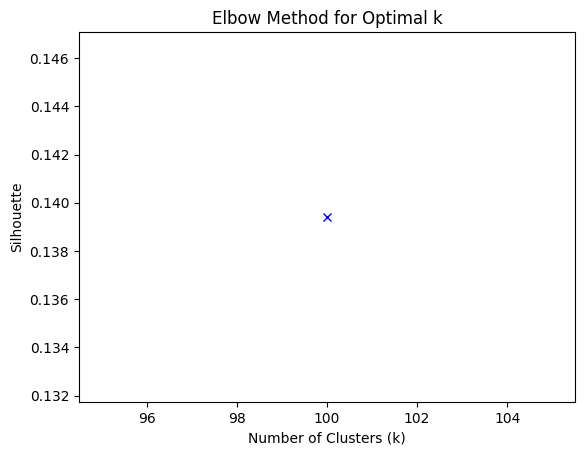

In [21]:
# def applying_elbow(df, features_col="pcaFeatures", prediction_col="cluster", min_k=60, max_k=100, random_seed=RANDOM_SEED):
clustering_results = applying_elbow(df_pca, features_col="pcaFeatures", prediction_col="cluster", min_k=100, max_k=101, random_seed=RANDOM_SEED)

In [22]:
# obatin the key of the max items of clustering_results
k_clustering = list(dict(sorted(clustering_results.items(), key=lambda item: item[1], reverse=True)))[0]

In [23]:
model, df_clusters = k_means(df_pca, 100, features_col="pcaFeatures", prediction_col="cluster", random_seed=RANDOM_SEED) # k_clustering or we can choose the number of clusters

k-means parameters: - number of clusters = 100 - max iterations = 80 - distance measure = euclidean - random seed = 42


In [24]:
df_clusters = df_clusters.withColumn("features", df_clusters["pcaFeatures"]) # we need to do this because the function evaluate_k_means needs a column named "features"
silhouette = evaluate_k_means(df_clusters, metric_name="silhouette", distance_measure="squaredEuclidean", prediction_col="cluster")

In [25]:
silhouette

0.1394490304733564

Joining the initial dataframe and the k-means resulting dataframe

In [26]:
#join the clusters_df with the original df on the key player_id
df_k_means = df.join(df_clusters, "player_id")

In [27]:
# show only if overall is greater than 80
df_k_means.filter(df.overall > 80).show(1000)

+---------+-------+---------+---------+--------------------+--------------+---------+-----------+-------------+----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+----------------+-------------------+-------------------+---------------------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+-----------------+--------------+--------------------+----------+------------------+---+--------------------+-------+--------------------+
|player_id|overall|height_c

In [28]:
#oridinare df_k_means per cluster
df_k_means = df_k_means.orderBy("cluster")

In [29]:
df_k_means.show(4000)

+---------+-------+---------+---------+--------------------+--------------+---------+-----------+-------------+----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+----------------+-------------------+-------------------+---------------------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+-----------------+--------------+--------------------+----------+------------------+---+--------------------+-------+--------------------+
|player_id|overall|height_c

## **Football players cluster scouting**

The clustering algorithm used grouped similar players together. From now on we could think of using the obtained partition in various ways:
- 

## **Clustering algorithms applications: k-prototypes** 

Loading task2dataset.csv as pandas dataframe

In [2]:
import pandas as pd
from kmodes.kprototypes import KPrototypes

In [3]:
# load task2dataset as pandas dataframe
df_p = pd.read_csv("task2dataset.csv")

In [4]:
# delete the column "features" from df_p
df_p = df_p.drop(columns=["name", "nationality_name"])

In [ ]:
df_p

In [ ]:
# list with the columns of the dataframe
# columns = list(df_p.columns)
# columns

In [7]:
# drop the columns in a list 
#columns_to_drop = list(set(list(df_p.columns)) - {"player_id", "overall", "height_cm", "preferred_foot", "skill_moves", "pace", "shooting", "passing", "dribbling", "defending", "physic", "last_valuation", "position", "sub_position", "age"})
# drop the columns in the list
#df_p = df_p.drop(columns=columns_to_drop)

In [ ]:
df_p

In [7]:
# Seleziona solo le colonne numeriche del DataFrame df_p
numeric_cols = (df_p.select_dtypes(include=[np.number]).columns).drop("player_id")

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Crea un oggetto StandardScaler
scaler = MinMaxScaler(feature_range=(0, 1000))

# Applica la standardizzazione alle colonne numeriche
df_p[numeric_cols] = scaler.fit_transform(df_p[numeric_cols])

In [ ]:
df_p

In [11]:
# multiplicate age and last_valuation for 1.3
df_p["age"] = df_p["age"] * 1.1
df_p["last_valuation"] = df_p["last_valuation"] * 1.1

In [9]:
df_p["player_id"] = df_p["player_id"] / 10000000

In [ ]:
numeric_cols

In [11]:
# print the indices of the categorical columns
categorical_cols = [i for i, x in enumerate(df_p.columns) if x not in numeric_cols]
print(categorical_cols)

[0, 4, 7, 50, 51]


In [12]:
mark_array = df_p.values

In [12]:
# from each array in mark_array, delete the first element (player_id)
mark_array = np.delete(mark_array, 0, 1)

In [13]:
# togliere -1 ad ogni elemento di categorical_cols
categorical_cols = [x - 1 for x in categorical_cols]

In [ ]:
kproto = KPrototypes(n_clusters=60, init='Cao', verbose=2, max_iter=50, n_init=5).fit(mark_array, categorical=list(set(categorical_cols) - {0}))

In [15]:
clusters = kproto.predict(mark_array, categorical=list(set(categorical_cols) - {0}))

In [16]:
df_p['cluster'] = list(clusters)

In [ ]:
df_p

In [18]:
# drop from df_p all the columns except player_id and cluster
df_p = df_p.drop(columns=list(set(df_p.columns) - {"player_id", "cluster"}))

In [19]:
# load task2dataset as pandas dataframe
df_task2dataset = pd.read_csv("task2dataset.csv")

#merge df and df_p on player_id
df_task2dataset = df_task2dataset.merge(df_p, on="player_id")

In [ ]:
pd.set_option('display.max_rows', None)    # Mostra tutte le righe
pd.set_option('display.max_columns', None) # Mostra tutte le colonne

In [ ]:
# mostra solo le istanze che hanno overall > 80
df_task2dataset[df_task2dataset["overall"] > 80]